![meme](https://i.imgflip.com/6x0g1f.jpg)

# Optimizing fantasy basketball

Fantasy basketball is an extremely popular pasttime for nba fans. Participants 'draft' players before the season, then get rewarded for their proxy's in-game performances during the season. 

One popular format is 'Head-to-Head: Most Categories'. Quoting from ESPN's description of the rules:

>Head-to-Head: Most Categories: H2H Most Categories allows you to set "X" number of statistic categories. For each scoring period (usually Monday through Sunday) team totals are accumulated in each of the categories. At the end of the scoring period, the winner is determined by which team wins the most number of categories. The end result is a win (1-0-0), loss (0-1-0) or tie (0-0-1). These results correspond directly to each team's overall record.

Common settings specify 9 categories: points, rebounds, assists, steals, blocks, 3-pointers, field goal %, free throw %, and turnovers. 

Participants are paired up to compete week-by-week, and at the end of the season, the player with the best record wins.

Understanding the game of basketball helps win fantasy drafts. However, it's not the whole ballgame: even if we had precise probability distributions for player performance beforehand, or exact numbers with no uncertainty, it would not be obvious how to draft correctly. Do we want to optimize for all 9 categories, or just some of them? Do we try to compete on the categories that other drafters are going for, or ones they are not? Do we embrace high-volatility players or low-volatility players? The problem becomes a rich mathematical one, more familiar to data scientists than to basketball enthusiasts

There is plenty of speculation about all this within the fantasy basketball community. However, few in the community realize that their strategies are leveraging high-level mathematical intuition. If we lean into the math, and treat this as an optimization problem, can we derive a method for fantasy drafting that delivers consistently high performance?

Our approach will be to break down the drafting problem into three mathematical steps
- Retrospectively drafting a full previous season, with full knowledge of player performance. Weekly totals will be randomly sampled from actual weekly totals for each player. Fantasy drafting this way becomes a full-information game, and therefore at least one Nash equilibrium exists. We will explore different ways of looking for it 
- Incorporating uncertainty into the priors of restrospective-drafting. We will explore how the strategy for retrospective drafting changes when there is uncertainty about the underlying probability distributions of player statistics
- Using predictive data science methods to make estimates of priors/posteriors for actual performance. This last step will allow us to design an actual drafting algorithm that could be used for a season of fantasy basketball

# Retrospective drafting

Let's lay out the infrastructure for the first step, retrospective drafting

In [65]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from itertools import combinations
from collections import Counter
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import copy
pd.set_option('display.max_rows', 100)
pd.options.mode.chained_assignment = None  # default='warn'

We will use the raw data from [Advanced Sports Analytics](https://www.advancedsportsanalytics.com/nba-raw-data), which has game-by-game player statistics

In [2]:
stat_df = pd.read_csv('../data/ASA All NBA Raw Data.csv')
essential_info = stat_df[['player','game_date','pts','trb','ast','stl','blk','fg3','fg','fga','ft','fta','tov']]

The most important infrastructure is code simulating an actual NBA fantasy season, so that we can evaluate the success of our strategies. Actually, since our model is probabilistic, we want to run many seasons and get the average # of wins

In [166]:
def run_multiple_seasons(teams
                         , n = 100 
                        ):
    #create a version of the essential info dataframe which incorporate team information for this season
    season_df = essential_info.drop(columns = 'game_date')
    season_df.loc[:,'team'] = season_df['player'].map(teams) 
    season_df = season_df.dropna()

    #use sampling to simulate many seasons at the same time
    #assuming each season has 11 weeks, we need 11 * n total rows of data per player
    #ZR: Note that for now a "week" of data is just one game per player
    #in real basketball multiple games are played per week, so we need to adjust for that 
    performances = season_df.groupby('player').sample(11*n, replace = True)
    performances.loc[:,'week'] = performances.groupby('player').cumcount()
    performances.loc[:,'season'] = performances['week'] // 11 #integer division seperates weeks in groups of 11

    #total team performances are simply the sum of statistics for each player 
    team_performances = performances.groupby(['season','team','week']).sum()
    
    #field goal % and free throw # are calculate on the aggregate level
    team_performances.loc[:,'fg_pct'] = np.where(team_performances['fga'] > 0
                                             ,team_performances['fg']/team_performances['fga']
                                             ,0)
    team_performances.loc[:,'ft_pct'] = np.where(team_performances['fta'] > 0
                                             ,team_performances['ft']/team_performances['fta']
                                             ,0)
    
    #for all categories except turnovers, higher numbers are better. So we invert turnovers 
    team_performances['tov'] = - team_performances['tov'] 
    team_performances = team_performances.drop(columns = ['fg','fga','ft','fta']) #only want category columns
    
    #we need to map each team to its opponent for the week. We do that with a formula for round robin pairing
    opposing_team_schedule = [(s,round_robin_opponent(t,w),w) for s, t, w in team_performances.index]
    opposing_team_performances = team_performances.loc[opposing_team_schedule]

    cat_losses = np.less(team_performances.values,opposing_team_performances.values).sum(axis = 1)
    cat_wins = np.greater(team_performances.values,opposing_team_performances.values).sum(axis = 1)

    team_performances.loc[:,'tie'] = cat_wins == cat_losses
    team_performances.loc[:,'win'] = cat_wins > cat_losses
    team_results = team_performances.groupby(['team','season']).agg({'win' : sum, 'tie' : sum})

    #a team cannot win the season if it has fewer wins than any other team 
    most_wins = team_results.groupby('season')['win'].transform('max')
    winners = team_results[team_results['win'] == most_wins]

    #among the teams with the most wins, ties are a tiebreaker 
    most_ties = winners.groupby('season')['tie'].transform('max')
    winners_after_ties = winners[winners['tie'] == most_ties]
    
    #assuming that payouts are divided when multiple teams are exactly tied, we give fractional points 
    winners_after_ties.loc[:,'winner_points'] = 1
    season_counts = winners_after_ties.groupby('season')['winner_points'].transform('count')
    winners_after_ties.loc[:,'winner_points_adjusted'] = 1/season_counts
    return winners_after_ties.groupby('team')['winner_points_adjusted'].sum()

We invoked a helper function above, "round_robin_opponent", without defining it. We need it to assign sensible pairings between competitors. Using [Wikipedia's algorithm for pairing a round robin](https://en.wikipedia.org/wiki/Round-robin_tournament#Circle_method) we can make this work via modular arithmetic

In [37]:
def round_robin_opponent(t
                         , w
                         , n =12): # n must be an even number
    
    if t == 0: #position 0 remains fixed, and the other teams rotate around their (n - 1) spots
        return ((n - 2 - w) % (n - 1) ) + 1
    elif ((t + w) % 11 ==0): # in spot (n-1) of the non-zero spots, the opponent is 0 
        return 0 
    else: #we calculate the current position of team, infer the opponent's position, then calculate the opposing team
        res = (((n - 1 - (t + w) % (n - 1)) % (n - 1))- w) % (n - 1)
        return (n - 1) if res == 0 else res
         

Now we also need to set up the drafting process. A simple drafter will use player stat totals, so we will create a table for them

In [3]:
player_totals = essential_info.drop(columns= 'game_date').groupby('player').sum()
player_totals.loc[:,'ft_pct'] = player_totals['ft']/player_totals['fta']
player_totals.loc[:,'fg_pct'] = player_totals['fg']/player_totals['fga']
player_totals = player_totals.drop(columns = ['ft','fta','fg','fga'])

Simple drafting agents will choose the top available player based on this table with some kind of scaling/weighting of categories

In [236]:
class simple_agent():
    
    def __init__(self
                 , punting_cats =[] #categories to completely ignore
                 , scaler = StandardScaler()):
        
        player_totals_scaled = pd.DataFrame(scaler.fit_transform(player_totals)
                                            , index = player_totals.index
                                            ,columns = player_totals.columns)
        player_totals_scaled['tov'] = - player_totals_scaled['tov']
        
        self.order = player_totals_scaled.drop(columns = punting_cats).sum(axis = 1).sort_values(ascending = False)

    def make_pick(self, player_assignments):
        
        available_players = self.order[~self.order.index.isin(player_assignments.keys())]
        chosen_player = available_players.index[0]
        
        return chosen_player

Drafts are typically run in the snake format. We'll consider a single round to be the back and forth of the snake- so for example with three drafters, player one picks, player two picks, player three picks two players, player two picks, and player one picks

In [214]:
def run_draft(agents, number_of_rounds):
    
    player_assignments = {}
    
    for i in range(number_of_rounds):
        for j in range(len(agents)):
            
            agent = agents[j]
            chosen_player = agent.make_pick(player_assignments)
            player_assignments[chosen_player] = j
            
        for j in reversed(range(len(agents))):
            agent = agents[j]
            chosen_player = agent.make_pick(player_assignments)
            player_assignments[chosen_player] = j

    return player_assignments

When we test a strategy, we want to see if it works broadly, not just in any one position. So we will create a helper function that tries a strategy in each position against some default agent in all the other positions

In [258]:
def try_strategy(primary_agent, default_agent, n_seasons):

    strategy_res = [[] for i in range(12)]
    for i in range(12):
        #we need to deepcopy the agents so that they don't share references with each other
        agents = [copy.deepcopy(default_agent) for x in range(i)] + \
                    [copy.deepcopy(primary_agent)] + \
                    [copy.deepcopy(default_agent) for x in range(11-i)]
        
        teams = run_draft(agents ,3)
        res = run_multiple_seasons(teams, n_seasons)
        strategy_res[i] = (res.get(i)) if (res.get(i)) is not None else 0 
    return np.sum(strategy_res)/(12*n_seasons) 


## 1a. Scaling Strategy

What's the best way to scale player stats?

In [259]:
agents = {'standard' : simple_agent(scaler = StandardScaler())
        , 'quantile' :  simple_agent(scaler = QuantileTransformer(n_quantiles = 621))
        , 'minmax' : simple_agent(scaler = MinMaxScaler())
         }

start = datetime.now()
combinatorial_results = pd.DataFrame(index = agents.keys(), columns = agents.keys())
for primary_agent_name in agents.keys():
    for default_agent_name in agents.keys():
        if primary_agent_name != default_agent_name:
            combinatorial_results.loc[primary_agent_name,default_agent_name] = try_strategy(
                                                                        agents[primary_agent_name]
                                                                        ,agents[default_agent_name]
                                                                        ,500)
print(datetime.now() - start)
combinatorial_results

0:00:35.932570


,standard,quantile,minmax
standard,NaN,0.107417,0.010986
quantile,0.052456,NaN,0.131722
minmax,0.029556,0.391531,NaN


Interestingly, no single option seems to be the best. StandardScaler() is generally quite good, but it struggles when it is the only StandardScaler() drafter and everybody else is using MinMaxScaler()

At some point we can also try 
- QuantileTransformer (Gaussian output)
- PowerTransformer (box-cox)
- RobustScaler

## 1b. Punting Strategy

Many players ignore one or two categories, with the theory that they can make up for losses in that category with strong performances in others. Let's test that

In [190]:
def try_punting_strategy(punting_cats, n = 500):
    primary_agent = simple_agent(punting_cats = punting_cats, scaler = StandardScaler())
    default_agent = simple_agent(punting_cats = [], scaler = StandardScaler())
    res = try_strategy(primary_agent, default_agent, n)
    variance = np.sqrt(res*(1-res)/(12 * n))
    return res, variance

In [191]:
start = datetime.now()
results = {cat : try_punting_strategy([cat]) for cat in player_totals.columns}
print(datetime.now() - start)

0:01:04.825371


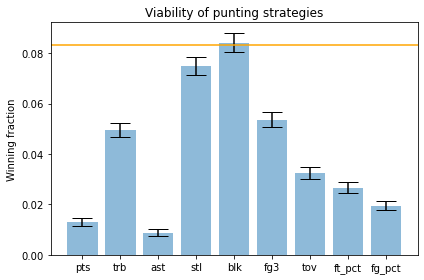

In [192]:
results_unpacked = list(map(list,zip(*[(x[0],x[1][0],x[1][1]) for x in results.items()])))

fig, ax = plt.subplots()

x_pos = np.arange(len(results_unpacked[0]))
ax.bar(x_pos
       , results_unpacked[1]
       , yerr=results_unpacked[2]
       , align='center'
       , alpha=0.5
       , ecolor='black'
       , capsize=10)

ax.set_ylabel('Winning fraction')
ax.set_xticks(x_pos)
ax.set_xticklabels(results_unpacked[0])
ax.set_title('Viability of punting strategies')
ax.axhline(y=1/12, color='orange', linestyle='-')

# Save the figure and show
plt.tight_layout()
plt.show()

Seems like punting blocks works reasonably well, but punting any other category decreases your chances of winning. This implies that ignoring points, or rebounds etc. doesn't help you enough in improving your other categories to be worth sacrificing one

## 1c. Balancing strategy

Players will often try to make their teams somewhat balanced. That is, if they already have a player who gets a lot of blocks, they might go for one who scores a lot of points. Let's try to implement that by assing a bonus factor for the product of all categories, disincentivizing specialization

In [263]:
class balanced_agent():
    
    def __init__(self, alpha = 1):
        
        player_totals_scaled = pd.DataFrame(MinMaxScaler().fit_transform(player_totals)
                                    , index = player_totals.index
                                    ,columns = player_totals.columns)
        player_totals_scaled['tov'] = 1 - player_totals_scaled['tov']
        
        player_totals_scaled.loc[:,'on_team'] = False
        self.stats = player_totals_scaled
        self.alpha = alpha
        
    def make_pick(self, player_assignments):
        
        current_stats = self.stats[self.stats['on_team']].drop(columns = 'on_team').sum(axis = 0)
        
        available_players = self.stats[~self.stats.index.isin(player_assignments.keys())].drop(columns = 'on_team')
        available_players.loc[:,'obj'] = [(row + current_stats).product()*self.alpha + (row + current_stats).sum()
                                          for i, row in available_players.iterrows()]
        chosen_player = available_players['obj'].idxmax()
        self.stats.loc[chosen_player,'on_team'] = True 
        return chosen_player

In [288]:
def try_alpha_strategy(alpha, n = 1000):
    primary_agent = balanced_agent(alpha = alpha)
    default_agent = simple_agent(punting_cats = [], scaler = MinMaxScaler())
    res = try_strategy(primary_agent, default_agent, n)
    variance = np.sqrt(res*(1-res)/(12 * n))
    return res, variance

In [289]:
start = datetime.now()
alpha_results = {alpha : try_alpha_strategy(alpha) for alpha in [0,0.05,0.1,0.15,0.2]}
print(datetime.now() - start)

0:01:45.562879


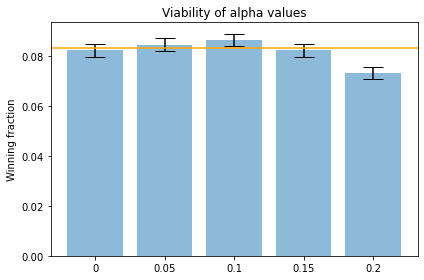

In [290]:
alpha_results_unpacked = list(map(list,zip(*[(x[0],x[1][0],x[1][1]) for x in alpha_results.items()])))

fig, ax = plt.subplots()

x_pos = np.arange(len(alpha_results_unpacked[0]))
ax.bar(x_pos
       , alpha_results_unpacked[1]
       , yerr=alpha_results_unpacked[2]
       , align='center'
       , alpha=0.5
       , ecolor='black'
       , capsize=10)

ax.set_ylabel('Winning fraction')
ax.set_xticks(x_pos)
ax.set_xticklabels(alpha_results_unpacked[0])
ax.set_title('Viability of alpha values')
ax.axhline(y=1/12, color='orange', linestyle='-')

# Save the figure and show
plt.tight_layout()
plt.show()

It seems like a small amount of balancing does help a bit, though the effect is small

Psuedocode and thoughts below here: 

In [ ]:

class gaussian_optimizer_agent():
    
    def __init__(self):
        
        #make a table with player averages + standard deviations as additional columns 
        
    def make_pick(self, player_assignments):
        
        #1. compute average stats of all players taken by other teams so far, mean and std. for each category
        #scale all the numbers up according to the round #, to get average team of correct size 
        
        #2.compute sum of all players you have taken so far, mean and std. for each category. Add those sums
        #to each potential new player, to calculate metric mean/std sums of your team if you take that new player 
        
        #3.for each set of team-level metrics corresponding to a potential new player, and for each category,
        #calculate probability of winning the category against the average team created in part 1
        #use the normal CDF formula: 1/2[1 + erf((M_yours - M_opposing) / sqrt(2)(s_yours + s_opposing))]
        
        #4. make a column for the probability of each winning category combination (e.g. win first 5, lose next 4)
        #there are 256 of them so the result will be a ~ 621 x 256 matrix
        
        #5. sum up the probabilities per player, and choose the player with the highest probability 
        
        self.stats.loc[chosen_player,'on_team'] = True 
        return chosen_player